# **Puerto Rico Supply & VPP Analysis** ⚡️🔋
_Daily stacked supply profiles + VPP contribution, with a zoom-in waterfall for the peak hour._

In [8]:
# Import Dependencies
import os, polars as pl, pandas as pd, numpy as np
import matplotlib.pyplot as plt, matplotlib as mpl
from matplotlib.ticker import StrMethodFormatter
from datetime import datetime, date, timedelta

## **I. One time plotting + display config**
Sets white plot backgrounds (nice in dark editors) and shows full Polars tables for quick inspection.

In [9]:
# Adjust specific configurations by choice

# Always white background in dark mode
mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white"
})

# Polars display
pl.Config.set_tbl_cols(-1) # Show all columns
pl.Config.set_tbl_rows(-1) # Show all rows

def ordinal(n: int) -> str:
    return f"{n}{'th' if 11 <= n % 100 <= 13 else {1: 'st', 2: 'nd', 3: 'rd'}.get(n % 10, 'th')}"

## **II. Load + clean (max discharge date and early casting)**
Exclude the late-start day, cast types once up front, and detect the day with the highest VPP discharge to anchor the analysis.

In [10]:
# Define base paths and directories
base = "/Users/jesusortiz/Documents/projects/02_energy"
input_01 = os.path.join(base, "01_data/01_luma_data")
input_02 = os.path.join(base, "01_data/02_tesla_data")
output_01 = os.path.join(base, "06_outputs/01_tables")
output_02 = os.path.join(base, "06_outputs/02_plots")

l_01 = pl.read_parquet(os.path.join(input_01, "*.parquet"))
t_01 = pl.read_parquet(os.path.join(input_02, "*.parquet"))

# Filter out startup date before casting
STARTUP_DATE_STR = "2025-08-03"
l_01 = l_01.filter(pl.col("date_collected") != STARTUP_DATE_STR)
t_01 = t_01.filter(pl.col("date_collected") != STARTUP_DATE_STR)

# Cast once, up-front
l_01 = l_01.with_columns(
    pl.col("max_amount").cast(pl.Float32),
    pl.col("act_amount").cast(pl.Float32),
    pl.col("date_collected").cast(pl.Date),
    pl.col("hour_run").cast(pl.Int32),
    pl.col("minute_run").cast(pl.Int32),
)

t_01 = t_01.with_columns(
    pl.col("value").cast(pl.Float32),
    pl.col("date_collected").cast(pl.Date),
    pl.col("hour_run").cast(pl.Int32),
    pl.col("minute_run").cast(pl.Int32),
)

# Find the date with highest Battery Discharge (after casting)
max_discharge = (
    t_01
    .filter(pl.col("variable") == "Battery Power - Discharging")
    .sort("value", descending=True)
    .select("date_collected")
    .to_series()
    .to_list()[0]
)

print("Max discharge date:", max_discharge)

Max discharge date: 2025-08-04


## **III. Coverage check**
Confirms both sources have at least one record per hour in the shared window; today is ignored to avoid partial-hour gaps.

In [11]:
# ## Data Coverage (hourly)
IGNORE_TODAY = True

def hourly_keys(df: pl.DataFrame) -> pl.DataFrame:
    return (
        df.select(["date_collected", "hour_run"])
          .drop_nulls(["date_collected", "hour_run"])
          .unique()
          .with_columns(
              (pl.col("date_collected").cast(pl.Datetime) + pl.duration(hours=pl.col("hour_run").cast(pl.Int64))).alias("ts")
          )
          .select(["date_collected", "hour_run", "ts"])
          .sort("ts")
    )

def min_max_ts(df: pl.DataFrame):
    if df.is_empty(): return None, None
    ts_min, ts_max = df.select(pl.col("ts").min().alias("ts_min"), pl.col("ts").max().alias("ts_max")).row(0)
    return ts_min, ts_max

def build_expected(start_dt: datetime, end_dt: datetime) -> pl.DataFrame:
    total_hours = int((end_dt - start_dt).total_seconds() // 3600) + 1
    rows = [((start_dt + timedelta(hours=i)).date(), (start_dt + timedelta(hours=i)).hour) for i in range(total_hours)]
    return pl.DataFrame(rows, schema={"date_collected": pl.Date, "hour_run": pl.Int32}, orient="row")

def check_missing_hours(l_01: pl.DataFrame, t_01: pl.DataFrame):
    l_hrs, t_hrs = hourly_keys(l_01), hourly_keys(t_01)
    l_min_ts, l_max_ts = min_max_ts(l_hrs)
    t_min_ts, t_max_ts = min_max_ts(t_hrs)
    if l_min_ts is None or t_min_ts is None:
        print("One of the datasets has no rows; cannot compute coverage."); return
    start = max(l_min_ts, t_min_ts)
    end = min(l_max_ts, t_max_ts)
    if IGNORE_TODAY:
        today = date.today()
        end = min(end, datetime.combine(today - timedelta(days=1), datetime.min.time()) + timedelta(hours=23))
    if end < start:
        print("Window collapses (likely only today's data). Skipping."); return
    expected = build_expected(start, end)
    missing_in_luma  = expected.join(l_hrs.select(["date_collected","hour_run"]), on=["date_collected","hour_run"], how="anti")
    missing_in_tesla = expected.join(t_hrs.select(["date_collected","hour_run"]), on=["date_collected","hour_run"], how="anti")
    if missing_in_luma.is_empty() and missing_in_tesla.is_empty():
        print("✅ Both datasets have at least one entry per hour (excluding today).")
    else:
        print("⚠️ Missing coverage (excluding today):")
        if not missing_in_luma.is_empty():  print("LUMA head:\n", missing_in_luma.head(20))
        if not missing_in_tesla.is_empty(): print("Tesla head:\n", missing_in_tesla.head(20))

check_missing_hours(l_01, t_01)


✅ Both datasets have at least one entry per hour (excluding today).


## **IV. Categorize + build hourly aggregate**
Tags LUMA rows as Supply/Demand/Reserve/Peak, keeps the earliest minute per hour to avoid double counting, and aggregates Supply by `source_tab`.

In [12]:

# Feature engineering (categories, earliest-minute logic)
supply_variables = ["AES","Aguirre","Cambalache","Ciclo Combinado Aguirre","Costa Sur","Eco Eléctrica",
                    "Gas de Vertedero","Hydroeléctrico","Mayaguez","Palo Seco","Palo Seco TM",
                    "San Juan","San Juan TM","Solar","Turbina de Gas","Viento"]
demand_variables  = ["Demanda Actual"]
reserve_variables = ["Reserva Actual"]
peak_variables    = ["Demanda Pico","Reserva Pico"]

# Add 'category' column to l_01
l_02 = (
    l_01
    .with_columns(
        pl.when(pl.col("variable").is_in(supply_variables)).then(pl.lit("Supply"))
        .when(pl.col("variable").is_in(demand_variables)).then(pl.lit("Demand"))
        .when(pl.col("variable").is_in(reserve_variables)).then(pl.lit("Reserve"))
        .when(pl.col("variable").is_in(peak_variables)).then(pl.lit("Peak"))
        .otherwise(pl.lit("Other"))
        .alias("category")
    )
)

# LUMA: earliest minute per plant per hour -> sum by source_tab/hour
l_03 = (
    l_02.filter((pl.col("date_collected") == max_discharge) & (pl.col("category") == "Supply"))
        .sort(["variable","source_tab","date_collected","hour_run","minute_run"])
        .group_by(["variable","source_tab","date_collected","hour_run"]).first()
        .group_by(["source_tab","date_collected","hour_run"])
        .agg(pl.col("act_amount").sum().round(0).alias("supply_mw"))
        .sort(["date_collected","hour_run","source_tab"])
)

# Tesla: earliest minute per hour -> sum (and keep a consistent label)
t_02 = (
    t_01.filter((pl.col("variable") == "Battery Power - Discharging") & (pl.col("date_collected") == max_discharge))
        .sort(["variable","date_collected","hour_run","minute_run"])
        .group_by(["variable","date_collected","hour_run"]).first()
        .group_by(["variable","date_collected","hour_run"])
        .agg(pl.col("value").sum().round(0).alias("supply_mw"))
        .rename({"variable":"source_tab"})
)

combined_df = pl.concat([l_03, t_02])

# Label harmonization
combined_df = combined_df.with_columns(
    pl.col("source_tab").replace({
        "Suministro Base": "Base Load",
        "Suministros Pico": "Peak Load",
        "Suministro Renovable": "Renewable Load",
        "Battery Power - Discharging": "VPP Discharge",
    })
)

df = combined_df.sort(["date_collected","hour_run"])
display(df.head(8))


source_tab,date_collected,hour_run,supply_mw
str,date,i32,f32
"""Base Load""",2025-08-04,0,1922.0
"""Renewable Load""",2025-08-04,0,3.0
"""Peak Load""",2025-08-04,0,387.0
"""VPP Discharge""",2025-08-04,0,5.0
"""Base Load""",2025-08-04,1,2016.0
"""Renewable Load""",2025-08-04,1,5.0
"""Peak Load""",2025-08-04,1,416.0
"""VPP Discharge""",2025-08-04,1,5.0


## **V. Stacked bars**
Daily mix across **Base / Peak / Renewable / VPP**; title states the peak hour and VPP share for a clear takeaway.

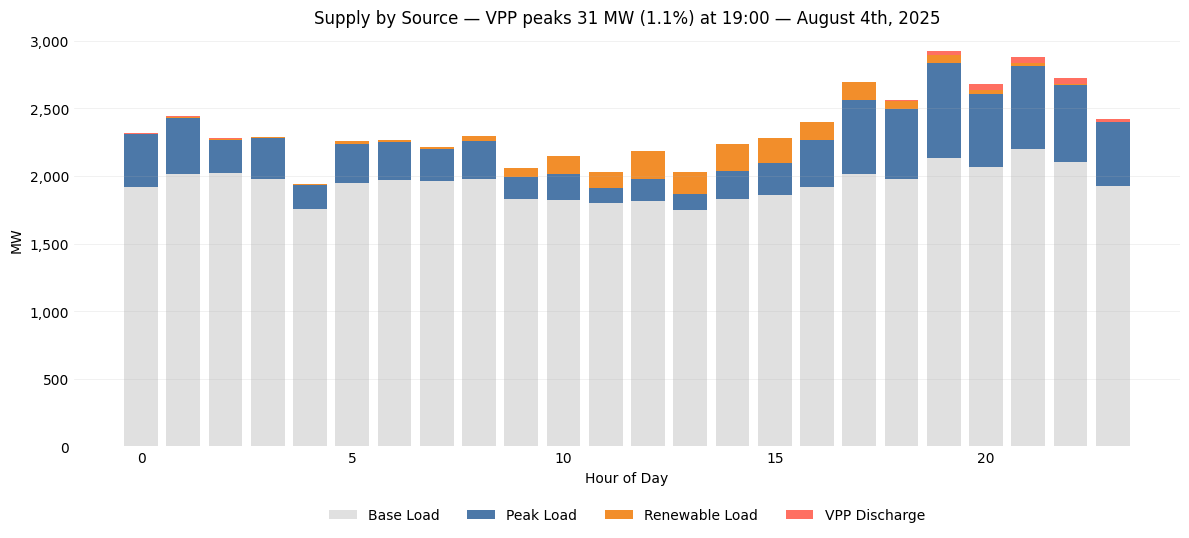

In [13]:
# Daily stacked supply with VPP
label_map = {
    "Suministro Base": "Base Load",
    "Suministro Pico": "Peak Load",
    "Suministros Pico": "Peak Load",
    "Suministro Renovable": "Renewable Load",
    "Battery Power - Discharging": "VPP Discharge",
}
order = ["Base Load","Peak Load","Renewable Load","VPP Discharge"]

df1 = df.with_columns(pl.col("source_tab").replace(label_map))

# unify value name to 'mw'
candidates = ["mw","supply_mw","battery_discharge_mw"]
present = [c for c in candidates if c in df1.columns]
df1 = df1.rename({present[0]: "mw"}) if len(present)==1 else df1.with_columns(pl.coalesce([pl.col(c) for c in present]).alias("mw"))

day = df1.select("date_collected").unique().item()
day_py = pd.to_datetime(str(day)).date()
pretty_day = f"{day_py.strftime('%B')} {ordinal(day_py.day)}, {day_py.year}"

# pivot: Polars >=1.0 uses `on=`
wide = (
    df1.filter(pl.col("date_collected")==day)
       .pivot(index="hour_run", on="source_tab", values="mw", aggregate_function="sum")
       .sort("hour_run")
)
for col in order:
    if col not in wide.columns: wide = wide.with_columns(pl.lit(0).alias(col))
all_hours = pl.DataFrame({"hour_run": list(range(24))})
wide = all_hours.join(wide, on="hour_run", how="left").with_columns(pl.all().exclude("hour_run").fill_null(0)).select(["hour_run"]+order)
pdf = wide.to_pandas().set_index("hour_run")

# palette (your final choices)
COL_BASE, COL_PEAK, COL_RENW, COL_VPP = "#E0E0E0", "#4C78A8", "#F28E2B", "#FF6F61"
colors = [COL_BASE,COL_PEAK,COL_RENW,COL_VPP]

fig, ax = plt.subplots(figsize=(12,5.5))
bottom = np.zeros(len(pdf), dtype=float)
for col, c in zip(order, colors):
    ax.bar(pdf.index, pdf[col].to_numpy(), bottom=bottom, label=col, color=c, linewidth=0)
    bottom += pdf[col].to_numpy()

total = pdf.sum(axis=1).to_numpy()
vpp   = pdf["VPP Discharge"].to_numpy()
peak_hr = int(np.nanargmax(total))
peak_total, peak_vpp = float(total[peak_hr]), float(vpp[peak_hr])
vpp_share = (peak_vpp/peak_total*100) if peak_total>0 else 0.0

ax.set_title(f"Supply by Source — VPP peaks {peak_vpp:,.0f} MW ({vpp_share:.1f}%) at {peak_hr:02d}:00 — {pretty_day}")
ax.set_xlabel("Hour of Day"); ax.set_ylabel("MW"); ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.grid(True, axis='y', linestyle='-', linewidth=0.5, alpha=0.25); ax.grid(False, axis='x')
for s in ("top","right","left","bottom"): ax.spines[s].set_visible(False)
ax.tick_params(axis='x', length=0); ax.tick_params(axis='y', length=0)
ax.legend(loc="upper center", bbox_to_anchor=(0.5,-0.12), ncol=4, frameon=False)
plt.tight_layout()
plt.show()


In [14]:
# Save figures

# name the file using the analysis day
fname = os.path.join(output_02, f"supply_stack_{day_py:%Y-%m-%d}")
fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight", facecolor="white")
# optional vector version for print/design
fig.savefig(f"{fname}.svg", bbox_inches="tight", facecolor="white")

## **VI. Waterfall**
oom-in on the peak hour to show how each component stacks up to the total.

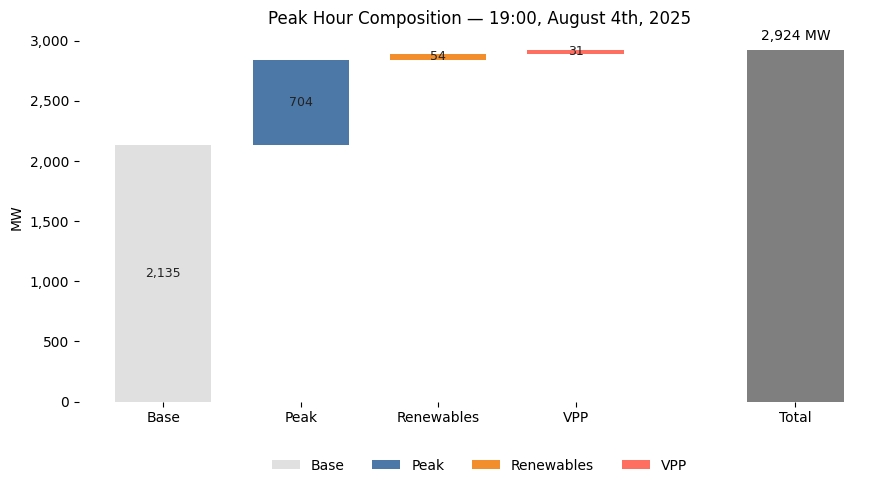

In [17]:
# Peak hour composition (waterfall)
order = ["Base Load","Peak Load","Renewable Load","VPP Discharge"]
df1 = df1  # from previous cell

totals = (df1.filter(pl.col("date_collected")==day)
             .group_by("hour_run")
             .agg(pl.col("mw").sum().alias("total"))
             .sort("hour_run"))
peak_hr, peak_total = totals.sort("total", descending=True).row(0)
peak_hr, peak_total = int(peak_hr), float(peak_total)

comp = (df1.filter((pl.col("date_collected")==day) & (pl.col("hour_run")==peak_hr) & (pl.col("source_tab").is_in(order)))
            .group_by("source_tab").agg(pl.col("mw").sum().alias("mw")))
vals_map = {k:0.0 for k in order}
vals_map.update({r[0]: float(r[1]) for r in comp.iter_rows()})
vals = [vals_map[k] for k in order]
labels = ["Base","Peak","Renewables","VPP"]

starts = np.r_[0, np.cumsum(vals)[:-1]]
x = np.arange(len(vals)); width = 0.7

COL_BASE, COL_PEAK, COL_RENW, COL_VPP, COL_TOTAL = "#E0E0E0","#4C78A8","#F28E2B","#FF6F61","#7F7F7F"
colors = [COL_BASE,COL_PEAK,COL_RENW,COL_VPP]

fig, ax = plt.subplots(figsize=(9,5))
for i,(s,v,c,lab) in enumerate(zip(starts, vals, colors, labels)):
    ax.bar(i, v, bottom=s, color=c, width=width, edgecolor="none", label=lab)
ax.bar(len(vals)+0.6, peak_total, color=COL_TOTAL, width=0.7, edgecolor="none")
ax.text(len(vals)+0.6, peak_total + peak_total*0.02, f"{peak_total:,.0f} MW", ha="center", va="bottom", fontsize=10)

for i,(s,v) in enumerate(zip(starts, vals)):
    if v>0: ax.text(i, s+v/2, f"{v:,.0f}", ha="center", va="center", fontsize=9, color="#222")

ax.set_title(f"Peak Hour Composition — {peak_hr:02d}:00, {pretty_day}")
ax.set_xticks(list(x)+[len(vals)+0.6]); ax.set_xticklabels(labels+["Total"])
ax.set_ylabel("MW"); ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

# ❌ no grid lines at all
ax.grid(False)

for s in ("top","right","left","bottom"): ax.spines[s].set_visible(False)
ax.legend(loc="upper center", bbox_to_anchor=(0.5,-0.12), ncol=5, frameon=False)

plt.tight_layout(); plt.show()

In [18]:
# include the peak hour in the filename (nice touch)
fname = os.path.join(output_02, f"peak_waterfall_{day_py:%Y-%m-%d}_{peak_hr:02d}00")
fig.savefig(f"{fname}.png", dpi=300, bbox_inches="tight", facecolor="white")
fig.savefig(f"{fname}.svg", bbox_inches="tight", facecolor="white")